In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load Data

In [2]:
#check the total image in train and image
data_path='../input/fruit-images-for-object-detection/'
train_path=os.path.join(data_path,'train_zip/train')
test_path=os.path.join(data_path,'test_zip/test')
print(f'total images in train are {len(os.listdir(train_path))}')
print(f'total images in test are {len(os.listdir(test_path))}')

total images in train are 480
total images in test are 120


we still do not know how many unique image in data. From train data, there are two type images, XML format and jpg format. Then, the image format is like 'apple_x.jpg'. The first word is the fruit name and the last word is number. So we can extract label of image by spliting filename

we define useful function to create data train, test, and labels

In [3]:
def convert_image(image_path,shape):
    """convert and resize image"""
    img=cv2.imread(image_path)
    img=cv2.resize(img,shape)/255
    return img

def making_labels(path):
    """create label from image"""
    labels=[]
    for file in os.listdir(path):
        if 'jpg' in file:
            label=file.split('_')[0]
            labels.append(label)
    return labels

def making_image(path, shape):
    data=[]
    for file in os.listdir(path):
        if 'jpg' in file:
            filepath=os.path.join(path,file)
            image=convert_image(filepath, shape)
            data.append(image)
    return np.array(data)

def making_dummies(path):
    labels=making_labels(path)
    return pd.get_dummies(labels).values

def split_data(images,labels,size):
    x_train, x_valid, y_train, y_valid=train_test_split(images,labels,test_size=size,random_state=1)
    return x_train, x_valid, y_train, y_valid
        

# EDA

We check class of data

In [4]:
print(f'image consists of {np.unique(making_labels(train_path))} unique data')

image consists of ['apple' 'banana' 'mixed' 'orange'] unique data


if we create dummies for labels, we obtain
apple=[1,0,0,0]
banana=[0,1,0,0]
mixed=[0,0,1,0]
orange=[0,0,0,1]

for analysis purpose, we create data frame of image

In [5]:
def get_filename(path):
    filename=[]
    for file in os.listdir(path):
        if 'jpg' in file:
            filename.append(file)
    return filename

train_df=pd.DataFrame()
train_df['file_name']=get_filename(train_path)
train_df['file_path']=[os.path.join(train_path,path) for path in os.listdir(train_path) if 'jpg' in path]
train_df['class']=making_labels(train_path)
train_df.head()

,file_name,file_path,class
0,banana_68.jpg,../input/fruit-images-for-object-detection/tra...,banana
1,apple_46.jpg,../input/fruit-images-for-object-detection/tra...,apple
2,orange_20.jpg,../input/fruit-images-for-object-detection/tra...,orange
3,mixed_1.jpg,../input/fruit-images-for-object-detection/tra...,mixed
4,apple_68.jpg,../input/fruit-images-for-object-detection/tra...,apple


In [6]:
test_df=pd.DataFrame()
test_df['file_name']=get_filename(test_path)
test_df['file_path']=[os.path.join(test_path,path) for path in os.listdir(test_path) if 'jpg' in path]
test_df['class']=making_labels(test_path)
test_df.head()

,file_name,file_path,class
0,apple_91.jpg,../input/fruit-images-for-object-detection/tes...,apple
1,mixed_21.jpg,../input/fruit-images-for-object-detection/tes...,mixed
2,orange_83.jpg,../input/fruit-images-for-object-detection/tes...,orange
3,orange_94.jpg,../input/fruit-images-for-object-detection/tes...,orange
4,apple_80.jpg,../input/fruit-images-for-object-detection/tes...,apple


the distribution of class is important for classification, so we need to check it

<AxesSubplot:xlabel='class', ylabel='Count'>

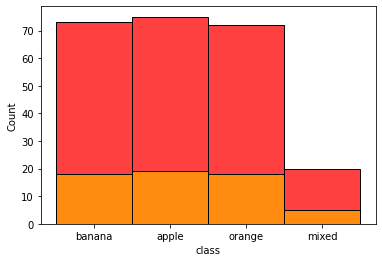

In [7]:
sns.histplot(train_df['class'],color='red',legend=True)
sns.histplot(test_df['class'],color='orange',legend=True)

banana, apple, and orange are equal, but mixed image is very low than others. So for this modeling, we keep it

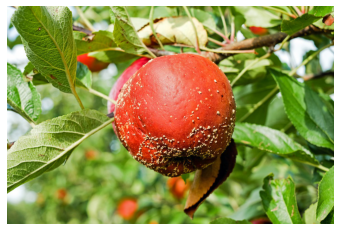

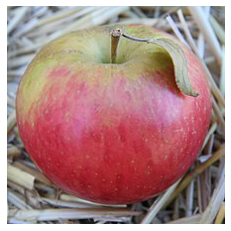

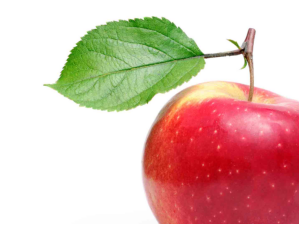

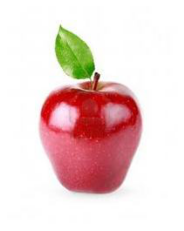

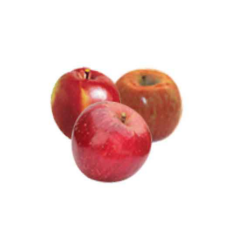

In [8]:
def show_img(df,cat):
    i=random.choice(range(len(df[df['class']==cat])))
    for n in range(i,i+5):
        img_path=df[df['class']==cat]['file_path'].to_list()
        img = mpimg.imread(img_path[n])
        plt.imshow(img)
        plt.axis('Off')
        plt.show()
show_img(train_df,'apple')

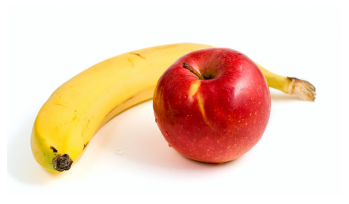

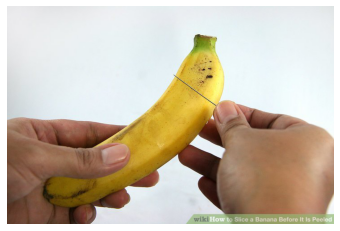

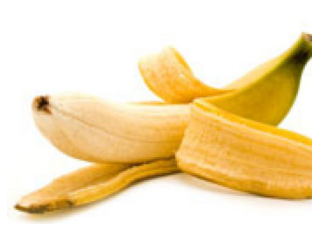

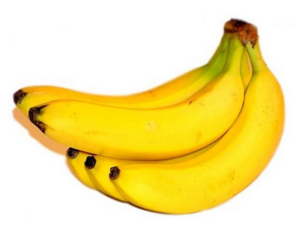

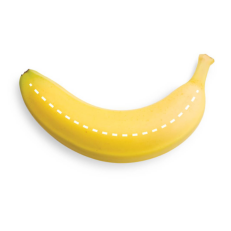

In [9]:
show_img(train_df,'banana')

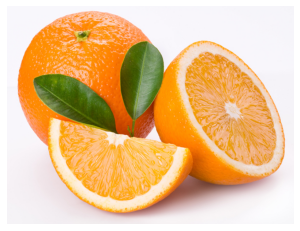

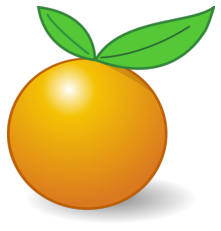

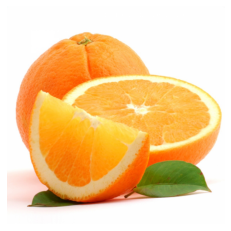

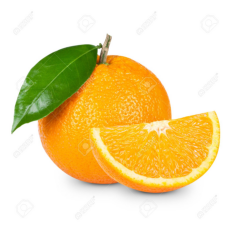

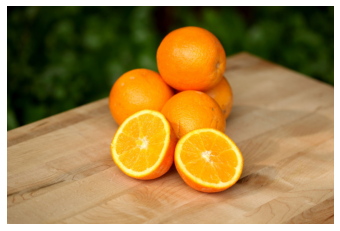

In [10]:
show_img(train_df,'orange')

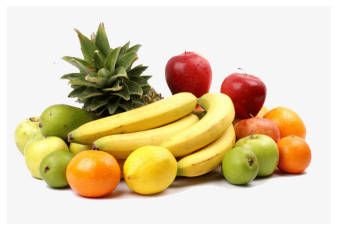

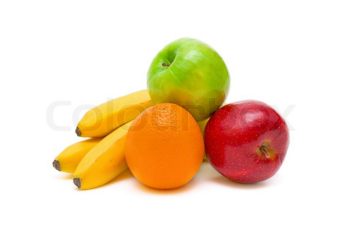

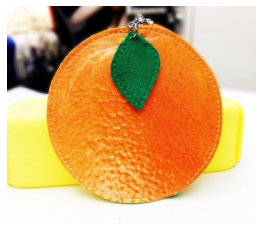

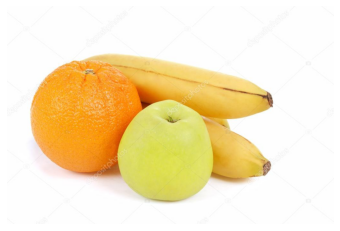

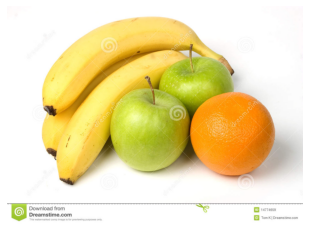

In [11]:
show_img(train_df,'mixed')

# Preprocessing

In [12]:
#create train image and train label
train_image=making_image(train_path,(200,200))
print(f'train shape: {train_image.shape}')
train_label=making_dummies(train_path)
print(f'train label: {train_label.shape}')

#create test image and test label
test_image=making_image(test_path,(200,200))
print(f'test shape: {test_image.shape}')
test_label=making_dummies(test_path)
print(f'test label: {test_label.shape}')

train shape: (240, 200, 200, 3)
train label: (240, 4)
test shape: (60, 200, 200, 3)
test label: (60, 4)


In [13]:
#spliting train and valid data
X_train, X_valid, y_train, y_valid= split_data(train_image, train_label,0.2)
print(X_train.shape)
print(X_valid.shape)

(192, 200, 200, 3)
(48, 200, 200, 3)


# Modeling

In [14]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam')

2022-05-16 06:45:10.635242: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

In [16]:
history=model.fit(X_train,y_train,epochs=50,batch_size=50,validation_data=(X_valid,y_valid))

2022-05-16 06:45:11.410025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
4/4 [==============================] - 11s 3s/step - loss: 1.9273 - acc: 0.2969 - val_loss: 1.3589 - val_acc: 0.1875
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 1.3383 - acc: 0.3281 - val_loss: 1.2448 - val_acc: 0.5625
Epoch 3/50
4/4 [==============================] - 10s 2s/step - loss: 1.2545 - acc: 0.4792 - val_loss: 1.0265 - val_acc: 0.8333
Epoch 4/50
4/4 [==============================] - 10s 2s/step - loss: 1.0829 - acc: 0.6510 - val_loss: 0.7091 - val_acc: 0.8333
Epoch 5/50
4/4 [==============================] - 10s 3s/step - loss: 0.7947 - acc: 0.7240 - val_loss: 0.4450 - val_acc: 0.9167
Epoch 6/50
4/4 [==============================] - 9s 2s/step - loss: 0.6661 - acc: 0.7656 - val_loss: 0.3354 - val_acc: 0.9167
Epoch 7/50
4/4 [==============================] - 10s 2s/step - loss: 0.5803 - acc: 0.7812 - val_loss: 0.2590 - val_acc: 0.9375
Epoch 8/50
4/4 [==============================] - 10s 3s/step - loss: 0.4301 - acc: 0.8542 - val_loss: 0.

<AxesSubplot:>

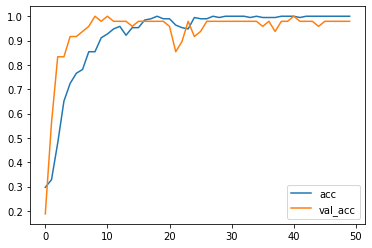

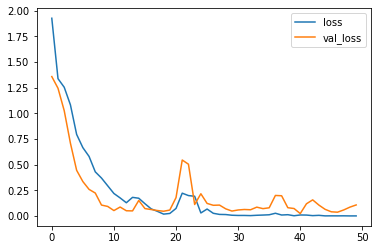

In [17]:
history_df=pd.DataFrame(history.history)
history_df[['acc','val_acc']].plot()
history_df[['loss','val_loss']].plot()

In [18]:
model.evaluate(X_valid,y_valid)

2/2 [==============================] - 1s 320ms/step - loss: 0.1074 - acc: 0.9792


[0.10736027359962463, 0.9791666865348816]

# Testing

[[0. 0. 0. 1.]]


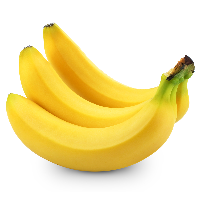

In [19]:
n=random.choice(range(len(test_df)))
img_path=test_df['file_path'].to_list()
img_show = tf.keras.preprocessing.image.load_img(img_path[n], target_size=(200, 200))
img = image.load_img(img_path[n], target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
        
images = np.vstack([x])
pred=model.predict(images, batch_size=10)
print(pred)
img_show

In [20]:
full_pred=model.predict(test_image, batch_size=10)
prediction=[]
pred_list=full_pred.tolist()
for row in pred_list:
    index=row.index(max(row))
    if index==0:
        prediction.append('apple')
    if index==1:
        prediction.append('banana')
    if index==2:
        prediction.append('mixed')
    if index==3:
        prediction.append('orange')
test_df['prediction']=prediction
test_df.head()

,file_name,file_path,class,prediction
0,apple_91.jpg,../input/fruit-images-for-object-detection/tes...,apple,apple
1,mixed_21.jpg,../input/fruit-images-for-object-detection/tes...,mixed,orange
2,orange_83.jpg,../input/fruit-images-for-object-detection/tes...,orange,orange
3,orange_94.jpg,../input/fruit-images-for-object-detection/tes...,orange,orange
4,apple_80.jpg,../input/fruit-images-for-object-detection/tes...,apple,apple


In [21]:
test_df.tail()

,file_name,file_path,class,prediction
55,apple_89.jpg,../input/fruit-images-for-object-detection/tes...,apple,apple
56,banana_78.jpg,../input/fruit-images-for-object-detection/tes...,banana,banana
57,mixed_25.jpg,../input/fruit-images-for-object-detection/tes...,mixed,apple
58,orange_81.jpg,../input/fruit-images-for-object-detection/tes...,orange,orange
59,banana_86.jpg,../input/fruit-images-for-object-detection/tes...,banana,orange


**THANK YOU!**